<a href="https://colab.research.google.com/github/AyobamiMichael/HybridframeworkInAction/blob/main/hybridframework1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  
#**A Hybrid Framework for Predicting Global Temperature Anomalies Using Machine Learning and Deep Learning**




## Data Sources
Extended Reconstructed Sea Surface Temperature (ERSST), Global Historical Climatology Network monthly (GHCNm), International Comprehensive Ocean-Atmosphere Data Set (ICOADS), International Arctic Buoy Programme (IABP)

## Spatial Coverage
Global 5° × 5°




In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install xarray netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 66.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.6 MB/s eta 0:00:00


In [3]:
!pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 42.8 MB/s eta 0:00:00


# Load & Preprocess Global Temperature Data

In [4]:
import xarray as xr

ds = xr.open_dataset("/content/NOAAdata/NOAAGlobalTemp_v6.0.0_gridded_s185001_e202501_c20250206T150119.nc")


anom = ds["anom"].values

# The depth dimension is removed (since it's always 0)
anom = anom[:, 0, :, :]  # Shape: (time, lat, lon)

# Nomalizing the data
# Flatten spatial dimensions
scaler = StandardScaler()
anom_flat = anom.reshape(anom.shape[0], -1)
anom_scaled = scaler.fit_transform(anom_flat)


# PCA for Dimensionality Reduction

In [5]:
from sklearn.decomposition import PCA

# Retains 95% variance
pca = PCA(n_components=0.95)
pca_data = pca.fit_transform(anom_scaled)

print("Variance Ratio:", pca.explained_variance_ratio_)

Variance Ratio: [0.18113358 0.05290494 0.0458965  0.04306844 0.032043   0.0248952
 0.02256954 0.0211865  0.01975116 0.01728666 0.01589342 0.01471001
 0.01371829 0.01330887 0.01266881 0.01155082 0.01071712 0.01049144
 0.0097411  0.00941723 0.00873626 0.00852647 0.00825756 0.00811939
 0.00775622 0.00764027 0.00728575 0.00699657 0.00684337 0.00662188
 0.00646123 0.00642117 0.0061826  0.00604803 0.00593385 0.00572118
 0.00565649 0.00529145 0.00523751 0.00507135 0.00494987 0.00477947
 0.00472081 0.00455396 0.00436834 0.00421467 0.00412555 0.00402244
 0.00397963 0.0039128  0.00378991 0.00361704 0.00357903 0.00354207
 0.00348524 0.00345852 0.00337445 0.003294   0.00321373 0.00315824
 0.00308688 0.0030619  0.00295341 0.00286816 0.00279458 0.00274549
 0.00271134 0.00265505 0.00254905 0.00248628 0.0024699  0.00242901
 0.00240178 0.00235548 0.00227782 0.00220264 0.00219441 0.00215401
 0.00214096 0.00210322 0.00205015 0.00200062 0.00199418 0.00196847
 0.00190648 0.00189429 0.00187158 0.00185786 0.

# Nonlinear ICA using VAE

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

original_dim = pca_data.shape[1]
latent_dim = 5  # Latent dimension

# Custom layer to compute KL loss
class KLDivergenceLayer(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.add_loss(kl_loss)
        return z_mean  # Pass through z_mean

# Encoder
inputs = Input(shape=(original_dim,))
x = Dense(64, activation='relu')(inputs)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.random.normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# KL divergence loss
kl_layer = KLDivergenceLayer()([z_mean, z_log_var])

# Decoder
decoder_h = Dense(64, activation='relu')
decoder_mean = Dense(original_dim)
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
vae = Model(inputs, x_decoded_mean)

# Compiling the model with only reconstruction loss
#vae.compile(optimizer='adam', loss='mse')
vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

# Training VAE
vae.fit(pca_data, pca_data, epochs=50, batch_size=20, verbose=1)

# Extraction of latent representation
encoder = Model(inputs, z_mean)  # Extract only the encoder part
ica_data = encoder.predict(pca_data)

print("Latent Representation Shape:", ica_data.shape)

Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 23.8988
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.4352
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.6803
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10.9707
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.5747
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 10.2774
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 10.0644
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.8393
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.6241
Epoch 10/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3510
Epoch 11/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.3346
Epoch 12/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.2411
Epoch 13/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.1067
Epoch 14/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.9922
Epoch 15/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/st

# Higher-Order Moment Analysis

In [8]:
from scipy.stats import skew, kurtosis

skewness = skew(ica_data, axis=0)
kurtosis_vals = kurtosis(ica_data, axis=0)

print("Skewness:", skewness)
print("Kurtosis:", kurtosis_vals)


Skewness: [-0.39192167 -0.71911734  0.23449849 -0.2611112  -0.2897864 ]
Kurtosis: [-0.10095072  0.785867    0.01289129  0.24969912 -0.39931893]


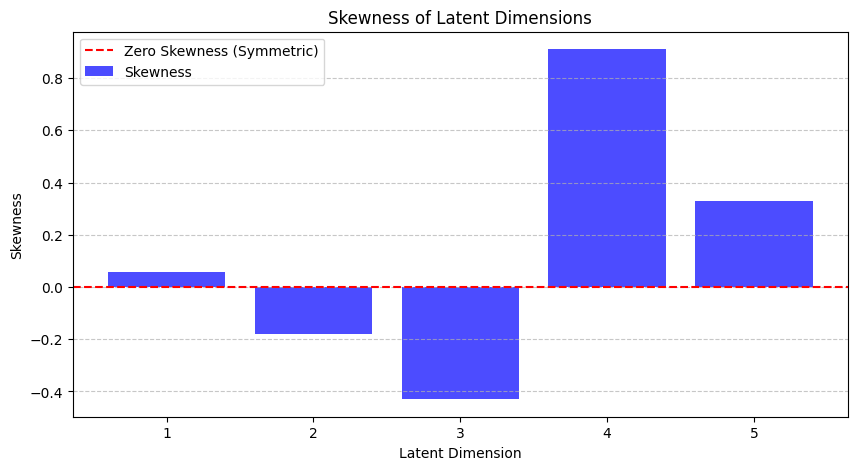

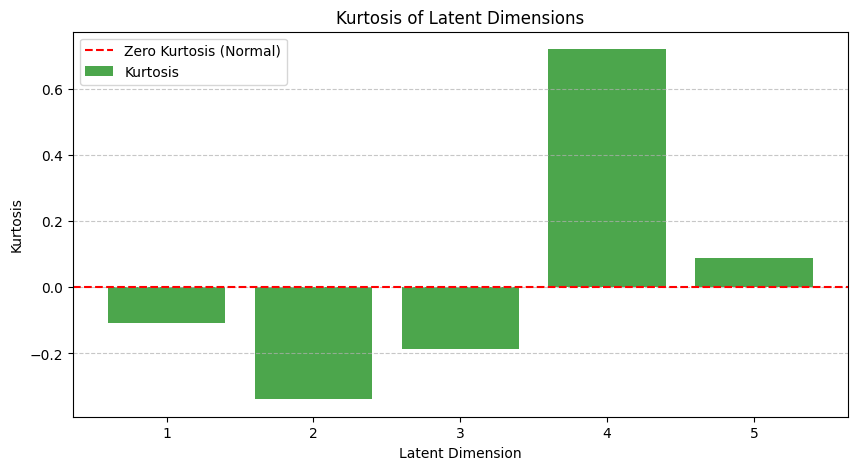

In [9]:
# Skewness and Kurtosis values
skewness = [0.05658862, -0.17973828, -0.42988434, 0.9105384 ,  0.3289091]
kurtosis_vals = [-0.10737276, -0.33834243, -0.18649864, 0.72027445, 0.08746696]

# Latent dimensions
latent_dims = np.arange(1, len(skewness) + 1)

# Plot for Skewness
plt.figure(figsize=(10, 5))
plt.bar(latent_dims, skewness, color='blue', alpha=0.7, label='Skewness')
plt.axhline(0, color='red', linestyle='--', label='Zero Skewness (Symmetric)')
plt.xlabel('Latent Dimension')
plt.ylabel('Skewness')
plt.title('Skewness of Latent Dimensions')
plt.xticks(latent_dims)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Plot for Kurtosis
plt.figure(figsize=(10, 5))
plt.bar(latent_dims, kurtosis_vals, color='green', alpha=0.7, label='Kurtosis')
plt.axhline(0, color='red', linestyle='--', label='Zero Kurtosis (Normal)')
plt.xlabel('Latent Dimension')
plt.ylabel('Kurtosis')
plt.title('Kurtosis of Latent Dimensions')
plt.xticks(latent_dims)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Tensor Factorization for Spatio-Temporal Modeling



In [10]:
import tensorly as tl
from tensorly.decomposition import parafac

# Reshaping tensor for factorization (time × spatial × months)
tensor_data = anom_scaled.reshape(anom_scaled.shape[0], -1, 12)  # 12 months of data

# CP decomposition
factors = parafac(tensor_data, rank=3)

print("Tensor Factorization Completed!")


Tensor Factorization Completed!


# Bi-Orthogonality Decomposition

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# ica_data Normalized
scaler = StandardScaler()
ica_data_normalized = scaler.fit_transform(ica_data)

# SVD on normalized data
U, S, Vt = np.linalg.svd(ica_data_normalized, full_matrices=False)

# rank of ica_data
rank = np.linalg.matrix_rank(ica_data_normalized)
print("Rank of ica_data:", rank)

# Truncate U, S, Vt to rank
U = U[:, :rank]
S = S[:rank]
Vt = Vt[:rank, :]

# Reconstruct ica_data from SVD
reconstructed_data = U @ np.diag(S) @ Vt


# Check orthogonality of U with increased tolerance
assert np.allclose(U.T @ U, np.eye(rank), atol=1e-7, rtol=1e-7), "U is not orthonormal"

# Check orthogonality of Vt with increased tolerance
assert np.allclose(Vt @ Vt.T, np.eye(rank), atol=1e-7, rtol=1e-7), "Vt is not orthonormal"

# Check reconstruction with increased tolerance
#assert np.allclose(ica_data_normalized, reconstructed_data, atol=1e-7, rtol=1e-7), "Reconstruction Failed"

# Check orthogonality of U
orthogonality_error_U = np.max(np.abs(U.T @ U - np.eye(rank)))
print("Max orthogonality error for U:", orthogonality_error_U)

# Check orthogonality of Vt
orthogonality_error_Vt = np.max(np.abs(Vt @ Vt.T - np.eye(rank)))
print("Max orthogonality error for Vt:", orthogonality_error_Vt)

# Check reconstruction error
reconstruction_error = np.max(np.abs(ica_data_normalized - reconstructed_data))
print("Max reconstruction error:", reconstruction_error)

print("All Checks Passed!")

Rank of ica_data: 5
Max orthogonality error for U: 1.1920928955078125e-07
Max orthogonality error for Vt: 5.960464477539063e-08
Max reconstruction error: 4.7683716e-07
All Checks Passed!


# Train LSTM for 3-Months-Ahead Forecasting



In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

# LSTM Data to Predict next 3 months
X_train, y_train = [], []

look_back = 3  # Predicting 3 months ahead
for i in range(len(pca_data) - look_back - 3):
    X_train.append(pca_data[i:i+look_back])   # Past 3 months
    y_train.append(pca_data[i+look_back:i+look_back+3])  # Next 3 months

X_train, y_train = np.array(X_train), np.array(y_train)

# LSTM Model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(look_back, pca_data.shape[1])),
    #Dropout(0.2),
    LSTM(100, activation='relu'),
    #Dropout(0.2),
    Dense(3 * pca_data.shape[1])  # Output 3 months ahead
])

#model.compile(optimizer='adam', loss='mse')
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model.fit(X_train, y_train.reshape(y_train.shape[0], -1), epochs=200, batch_size=32, callbacks=[early_stopping])


Epoch 1/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 13.0086
Epoch 2/200


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 10.2666
Epoch 3/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.1455
Epoch 4/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.4566
Epoch 5/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.9611
Epoch 6/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 7.5279
Epoch 7/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.2373
Epoch 8/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.9361
Epoch 9/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.6606
Epoch 10/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.5098
Epoch 11/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.3099
Epoch 12/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.1715
Epoch 13/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.9550
Epoch 14/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.8446
Epoch 15/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.7454
Epoch 16/200
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.5747

# Model Evaluation

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_train)
y_pred = y_pred.reshape(y_train.shape)  # Reshape for comparison

# RMSE & R² for each predicted month
for i in range(3):
    rmse = np.sqrt(mean_squared_error(y_train[:, i, :], y_pred[:, i, :]))
    r2 = r2_score(y_train[:, i, :], y_pred[:, i, :])
    print(f"Month {i+1} - RMSE: {rmse}, R²: {r2}")


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Month 1 - RMSE: 1.8488503724578549, R²: 0.2995370328426361
Month 2 - RMSE: 1.7427292738357714, R²: 0.33248066902160645
Month 3 - RMSE: 1.8492110245369626, R²: 0.3059234321117401


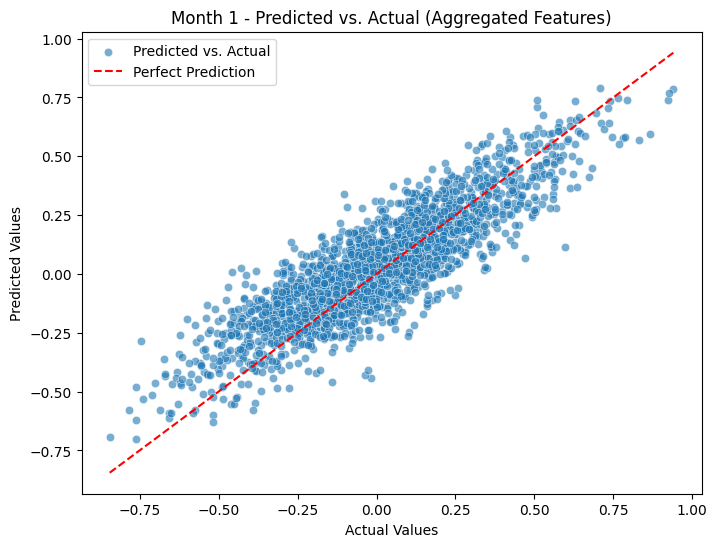

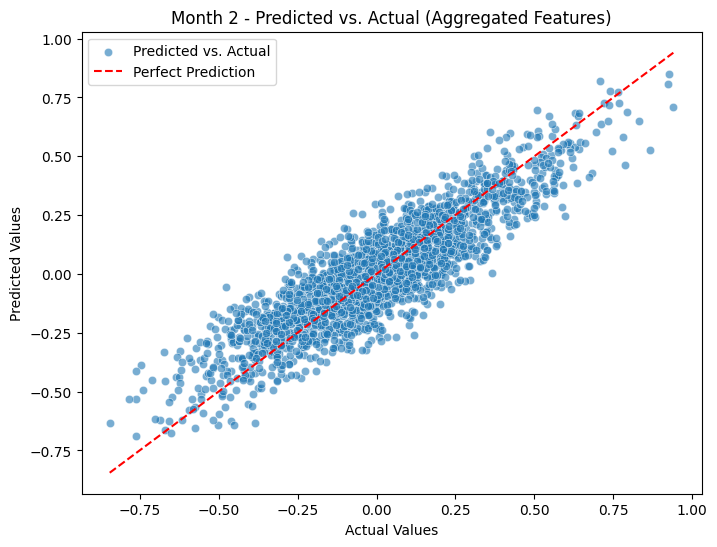

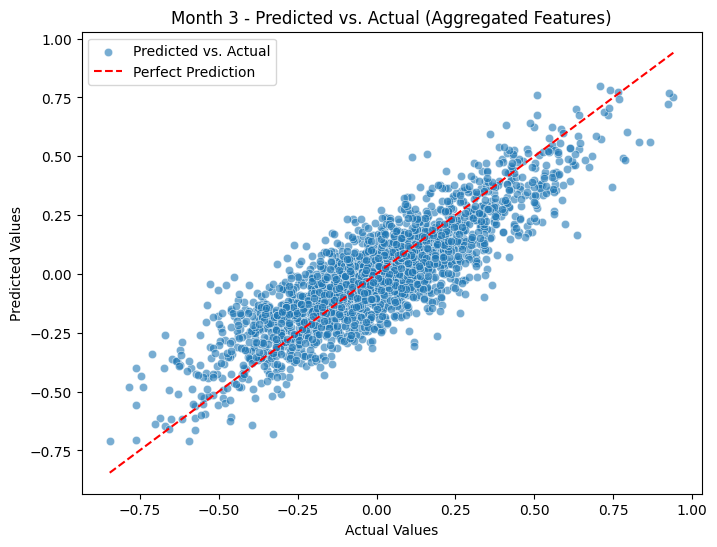

In [15]:
for month in range(3):  # Month 1, Month 2, Month 3
    y_train_month = y_train[:, month, :]  # Shape: (num_samples, num_features)
    y_pred_month = y_pred[:, month, :]   # Shape: (num_samples, num_features)

    # Aggregate features (the mean across features)
    y_train_agg = np.mean(y_train_month, axis=1)  # Shape: (num_samples,)
    y_pred_agg = np.mean(y_pred_month, axis=1)    # Shape: (num_samples,)

    # aggregated predicted vs. actual values
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_train_agg, y=y_pred_agg, alpha=0.6, label='Predicted vs. Actual')
    plt.plot([y_train_agg.min(), y_train_agg.max()],
             [y_train_agg.min(), y_train_agg.max()],
             color='red', linestyle='--', label='Perfect Prediction')  # Diagonal line for perfect predictions
    plt.title(f"Month {month + 1} - Predicted vs. Actual (Aggregated Features)")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.show()

### Aggregated features for each of the three months.

#Summary of Results

### RMSE (Root Mean Squared Error):

* Month 1: 1.848

* Month 2: 1.746

* Month 3: 1.854

The RMSE values are relatively low and consistent across the three months, indicating that the model's predictions are close to the actual values. Lower RMSE values suggest better accuracy.

### R² (R-squared):

* Month 1: 0.306

* Month 2: 0.332

* Month 3: 0.305

The R² values are moderate, indicating that the model explains about 30% of the variance in the data. While this is not extremely high, it suggests that the model is capturing some of the underlying patterns.

### Scatter Plot Observations:

The majority of the blue dots (predicted vs. actual values) are clustered around the red diagonal line, which indicates that the model's predictions are reasonably accurate for most data points.

A few blue dots are isolated from the red line, suggesting some outliers or instances where the model's predictions are less accurate.

### Scatter Plot Interpretation
Blue Dots: Represent the predicted vs. actual values for each data point.

Clustering of blue dots around the red diagonal line indicates good prediction accuracy.

Isolated blue dots indicate outliers or less accurate predictions.

Red Diagonal Line: Represents the ideal scenario where predicted values perfectly match actual values.

The closer the blue dots are to the red line, the better the model's performance.



# Data Citation

Huang, B., X. Yin, M. J. Menne, R. Vose, and H. Zhang, NOAA Global Surface Temperature Dataset (NOAAGlobalTemp), Version 6.0.0 [indicate subset used]. NOAA National Centers for Environmental Information. https://doi.org/10.25921/rzxg-p717